In [1]:
import json
import os
import ml_collections
from lightning.pytorch import seed_everything
from seisLM.model.foundation.pretrained_models import LitMultiDimWav2Vec2
from seisLM.data_pipeline import collator
from seisLM.data_pipeline import seisbench_dataloaders as dataloaders
import matplotlib.pyplot as plt
import tqdm

config_path = '/scicore/home/dokman0000/liu0003/projects/seisLM/seisLM/configs/pretrain/pretrain_config_rmsnorm_std_nomean_reduce_codevectors_rope.json'
with open(config_path, "r", encoding="utf-8") as f:
  config = json.load(f)
config = ml_collections.ConfigDict(config)
config.data_config.local_batch_size = 128

#### Override config
config.data_config.amp_norm_type = 'std'

In [ ]:
seed_everything(config.seed)
model = LitMultiDimWav2Vec2(config)

DEFAULT_NUM_WORKERS = 4

data_collator = \
  collator.DataCollatorForWav2Vec2PretrainingConcatChannelsNoPadding(
      config=config.model_config,
      mask_time_prob=config.training_config.mask_time_prob,
      mask_time_length=config.training_config.mask_time_length,
  )

config.data_config.num_workers = int(
    os.environ.get('SLURM_CPUS_PER_TASK', DEFAULT_NUM_WORKERS))


Seed set to 42


In [ ]:
all_data_name = [
      # "ETHZ",
      "GEOFON",
      # "STEAD",
      # "NEIC",
      # "InstanceCounts",
      # "Iquique"
    ][::-1] # 'ETHZ', 'GEOFON'


for data_name in all_data_name:
  print(f'Processing {data_name}')
  train_loader, dev_loader = dataloaders.prepare_seisbench_dataloaders(
    model=model,
    training_fraction=config.data_config.training_fraction,
    data_names=[data_name],
    batch_size=config.data_config.local_batch_size,
    num_workers=config.data_config.num_workers,
    prefetch_factor=config.data_config.prefetch_factor,
    collator=data_collator,
    cache=config.data_config.cache_dataset,
  )

  loader = dev_loader
  max_input_values = 0.0
  idx = 0
  for batch in tqdm.tqdm(dev_loader):
    input_values = batch['input_values']
    curr_max = input_values.abs().max().item()
    if curr_max > max_input_values:
      max_input_values = curr_max

    if max_input_values > 100:
      print(f'dataset {data_name} abnormal max_input_values: {max_input_values} > 100 at idx {idx}; break \n')
      break
    idx += 1
  print(f'dataset {data_name} max_input_values: {max_input_values} \n')

Processing GEOFON


 50%|█████     | 109/217 [01:12<01:13,  1.46it/s]

dataset GEOFON abnormal max_input_values: 1042.52587890625 > 100 at idx 110; break 



 51%|█████     | 110/217 [01:14<01:12,  1.47it/s]

dataset GEOFON max_input_values: 1042.52587890625 



abnormal sample


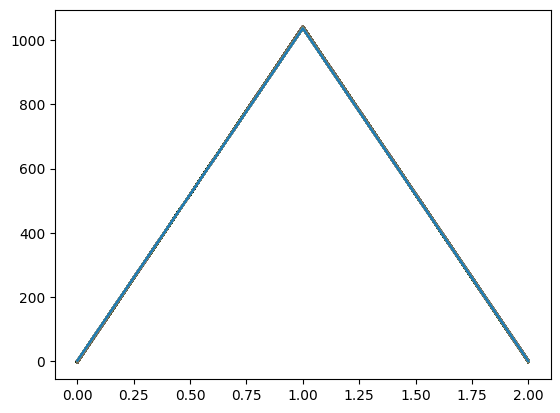

In [16]:
for sample in batch['input_values']:
  if sample.abs().max().item() > 100:
    plt.figure()
    print('abnormal sample')
    plt.plot(sample)
    plt.show()
    break



In [12]:
batch

{'input_values': tensor([[[ 6.7002e-02,  6.7829e-02,  6.8975e-02,  ..., -1.1455e+00,
           -1.1448e+00, -1.1438e+00],
          [ 1.6438e-01,  1.6150e-01,  1.5802e-01,  ..., -1.2395e-02,
            2.5864e-04,  1.2147e-02],
          [-3.3487e-01, -3.4436e-01, -3.5398e-01,  ...,  8.2582e-01,
            8.2110e-01,  8.1694e-01]],
 
         [[ 1.4283e+00,  1.4318e+00,  1.4364e+00,  ...,  1.6336e+00,
            1.6297e+00,  1.6261e+00],
          [ 2.1940e+00,  2.2124e+00,  2.2310e+00,  ..., -5.8896e-01,
           -5.7984e-01, -5.7481e-01],
          [-2.4888e+00, -2.4883e+00, -2.4870e+00,  ...,  7.1613e-01,
            7.1228e-01,  7.0911e-01]],
 
         [[ 3.5435e-01,  3.5242e-01,  3.5049e-01,  ..., -1.6011e+00,
           -1.5972e+00, -1.5932e+00],
          [ 1.2996e+00,  1.3062e+00,  1.3118e+00,  ..., -9.2367e-01,
           -9.4390e-01, -9.6175e-01],
          [ 8.3960e-01,  8.4357e-01,  8.4762e-01,  ..., -1.7635e+00,
           -1.7582e+00, -1.7535e+00]],
 
         ...

In [ ]:
plt.plot( (input_values[idx] / input_values[idx].std()).T)

NameError: name 'idx' is not defined

In [ ]:
batch['input_values'].abs().max()

tensor(14.9579)

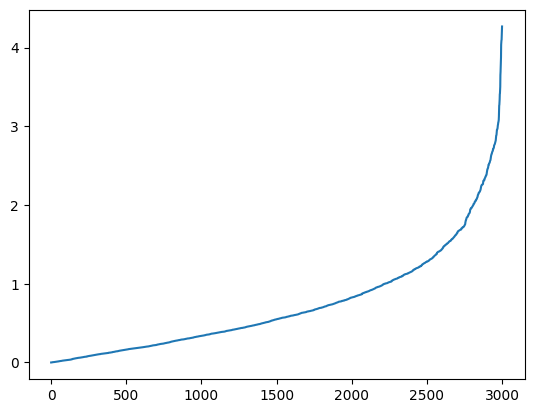

In [ ]:
plt.plot(
  batch['input_values'][idx][0].abs().sort().values
)

tensor(4.8406)

In [ ]:
input_values[idx]

tensor([[-1.4039e-01, -1.5827e-01, -1.6510e-01,  ..., -1.8055e+00,
         -3.7110e+00, -5.1438e+00],
        [-1.0000e+10, -1.0000e+10, -1.0000e+10,  ..., -1.0000e+10,
         -1.0000e+10, -1.0000e+10],
        [ 1.3505e-01,  1.5540e-01,  1.6325e-01,  ...,  1.7892e+00,
          3.6996e+00,  5.1421e+00]])

In [ ]:
len(train_loader)

105152